In [1]:
from read_mem import *
import matplotlib.pyplot as plt
import pathlib
from parse import parse
import json
from scipy.optimize import curve_fit

In [2]:
def func(x, a, b,):

    return a * x + b

Total number of log files 11
443751 /home/bastian/D1/registration/hubertest_coarse/443751/RK10A100.0LBFGS40
/home/bastian/D1/registration/mri2fem-dataset/processed/coarsecropped/coarsenedabbytoernie.mgz
443752 /home/bastian/D1/registration/hubertest_coarse/443752/RK10A100.0LBFGS40
/home/bastian/D1/registration/mri2fem-dataset/processed/coarsecropped/coarsenedabbytoernie.mgz
443759 /home/bastian/D1/registration/hubertest_coarse/443759/E10A100.0LBFGS40
/home/bastian/D1/registration/mri2fem-dataset/processed/coarsecropped/coarsenedabbytoernie.mgz
443761 /home/bastian/D1/registration/hubertest_coarse/443761/E10A100.0LBFGS40
/home/bastian/D1/registration/mri2fem-dataset/processed/coarsecropped/coarsenedabbytoernie.mgz
443871 /home/bastian/d1/registration/hubertest_coarse/443871/E10A100.0LBFGS40
/home/bastian/d1/registration/mri2fem-dataset/processed/coarsecropped/coarsenedabbytoernie.mgz
443873 /home/bastian/d1/registration/mrislurm/443873/RK10A100.0LBFGS40
/home/bastian/d1/registration/mri

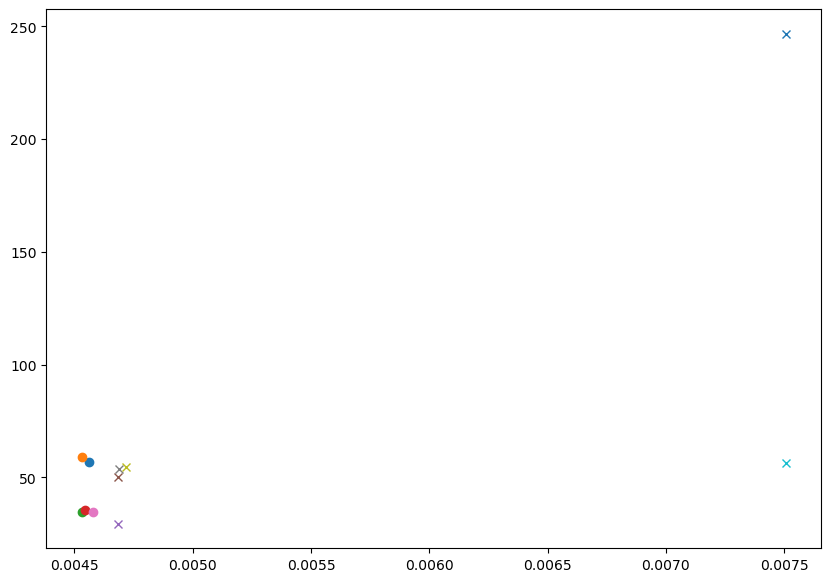

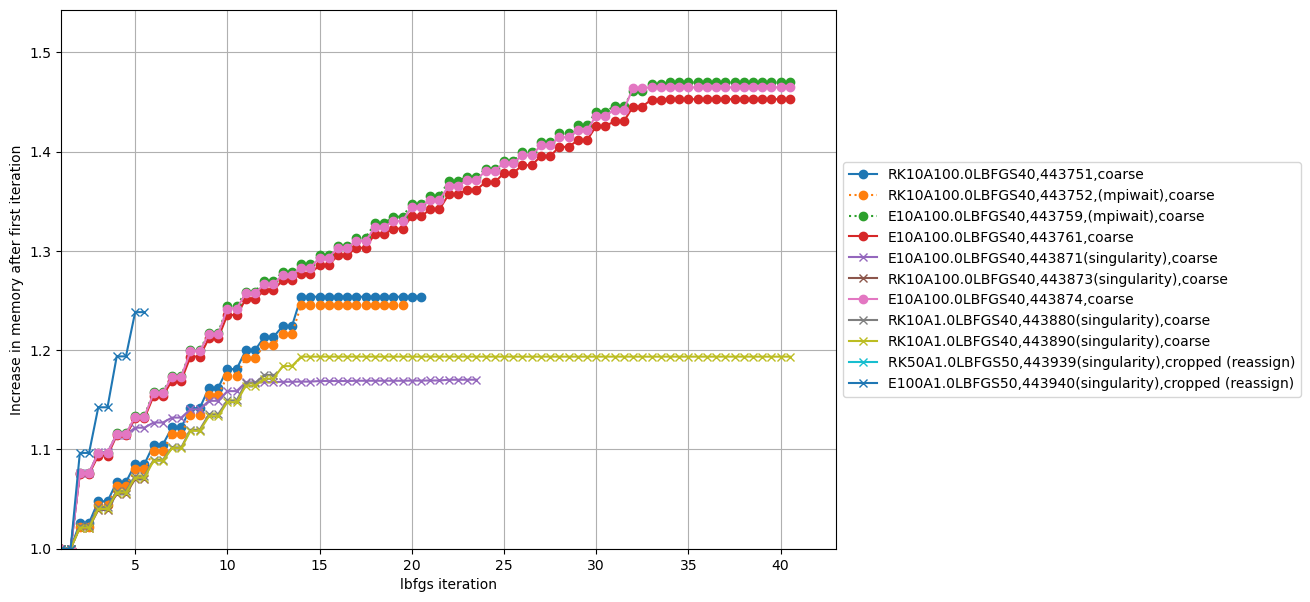

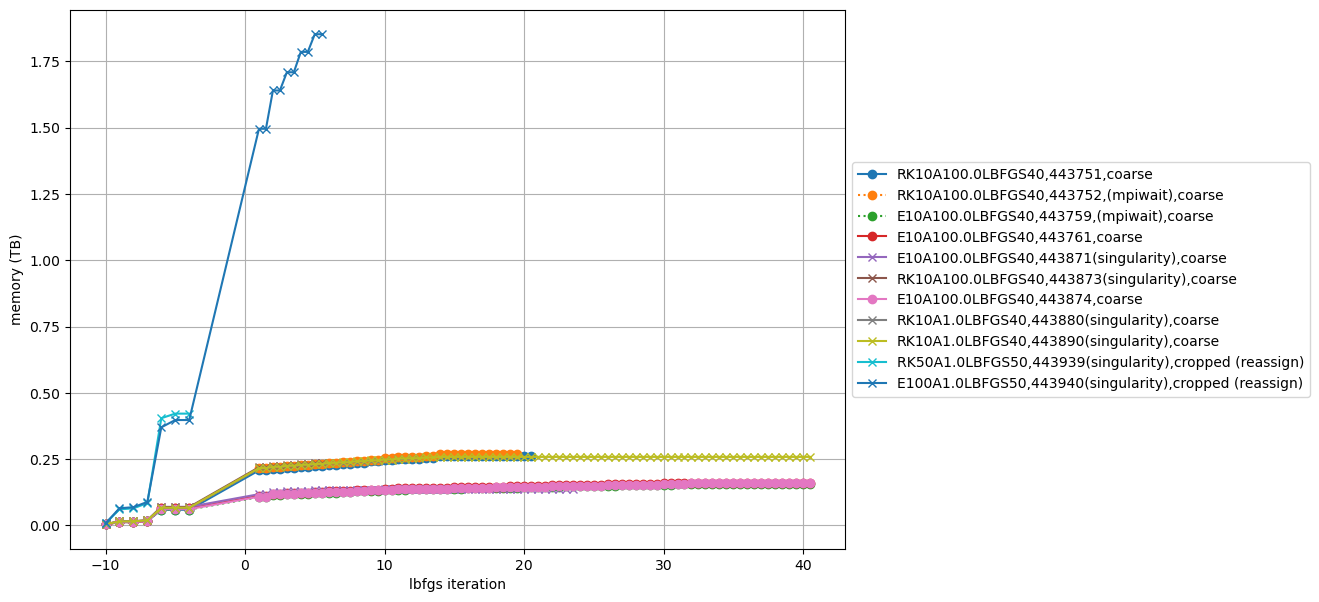

In [5]:
slurmids=[]
path = pathlib.Path("/home/bastian/D1/registration/mrislurm/")
slurmids = [
    441149, 441152, 441153, 
    # no preconditioning:
    441187, 441188, 441189, 
    441203, 441153, 
    441265, 441367, 441419,
    441443, 441444,
]

# compare mpi.barrier to not having barrier:
slurmids = [
    443751,
    443759, 443752,
    # # euler:
    443761, 443874,
    # # from singularity: 
     443871, 443873, # 443875, 443874, 443877,
    443880, 443890,
    443939, 443940
]

# slurmids = [441447, 441448,
#         441699, 441700,
#         441776, 441778, 441955
# ]


# slurmids = [
# 443619
# ]

print("Total number of log files", len(slurmids))

fig3 = plt.figure(figsize=(10,7))
ax3 = plt.subplot(111)

fig2 = plt.figure(figsize=(10,7))
ax2 = plt.subplot(111)

fig = plt.figure(figsize=(10,7))
ax = plt.subplot(111)

colors = {1: "darkblue", 2: "blue", 4:"deepskyblue", 8:"slategrey", 10: "k"}

for slurmid in sorted(slurmids):

    try:
        filename = path / (str(slurmid) + "_log_python_srun.txt")
        mema, outfoldername, line_searches, outputfolder = read_memory(filename)

        hyperparameters = json.load(open(outputfolder.replace("d1", "D1") + "/hyperparameters.json"))
    except FileNotFoundError:

        hyperparameters = {"input": ""}
        print("Did not find", slurmid)
        # continue

    # check_for_error(path / (str(slurmid) + ".out"))
    check(filename)#path / (str(slurmid) + ".out"))

    ntasks = None
    ntasks, maxcor, meshn = read(path / (str(slurmid) + ".out"))

    outfoldername = outfoldername.replace("\n", "").replace(" ", "")
    
    print(slurmid, outputfolder)
    print(hyperparameters["input"])
    
    # if not "coarse" in hyperparameters["input"]:
    #     print("continue")
    #     continue

    try:
        mema[:,0]
        # print(mema[:, 0])
    except IndexError:
        print(slurmid, outfoldername, "probably still running init? Continue.")
        continue

    marker = "o"
    linestyle = "-"
    fac2 = mema[np.argmin(np.abs(mema[:, 0]-1)),1]
    # popt, pcov = curve_fit(func, mema[:10,0]-1, mema[:10, 1])
    # print(slurmid, "linear slope=", popt[0], "slope/b", popt[0] / popt[1])

    label = outfoldername + "," + str(slurmid) #  + ",N=" + str(ntasks)

    if ntasks is not None:
        label += str(ntasks).replace("\n", "")

    color = None

    if "preconditioning" in hyperparameters.keys() and hyperparameters["preconditioning"] == "none":
        # continue
        linestyle = ":"
        label += ",(no preconditioning)"


    if "not_store_solver" in hyperparameters.keys() and hyperparameters["not_store_solver"]:
        # continue
        linestyle = ":"
        label += ",(not_store_solver)"
    if "mpiwait" in hyperparameters.keys() and hyperparameters["mpiwait"]:
        # continue
        linestyle = ":"
        label += ",(mpiwait)"

    if "/home/bastian/d1/registration/" in hyperparameters["logfile"]:
        label += "(singularity)"
        marker = "x"


    # elif hyperparameters["smoothen"] is False:
    #     pass
    #     # continue
    # else:
    #     # pass
    #     continue

    if "RK" in outfoldername:
        color = "r"
    else:
        color = "g"

    if "coarsecropped" in hyperparameters["input"]:
        # color = "b"
        label += ",coarse"

    elif "cropped" in hyperparameters["input"]:
        color = "c"
        label += ",cropped"
    elif "affine" in hyperparameters["input"]:
        color = "m"
        label += ",affine-rotated"

    # if "padding" in hyperparameters.keys() and hyperparameters["padding"] is not None:
    #     continue

    # if "coarsecropped" not in hyperparameters["input"]:
    #     continue

    color = None

    if "mpiexec" in outfoldername:
        label += " (mpiexec)"
        linestyle = "--"

    if "reassign" in hyperparameters.keys() and hyperparameters["reassign"]:
        marker = "x"
        label += " (reassign)"

    if "padding" in hyperparameters.keys() and hyperparameters["padding"] is not None:
        color = "b"
        label += ",pad=" + str(hyperparameters["padding"])
        plt.text(mema[-1, 0], mema[-1, 1], s=str(hyperparameters["padding"]))
        ax2.text(mema[-1, 0], mema[-1, 1] / fac2, s=str(hyperparameters["padding"]))

    # print(slurmid, (mema[1:, 1] - mema[:-1,1]))



    line = plt.plot(mema[:,0], mema[:,1], marker=marker, linestyle=linestyle, color=color,
            label=label,
            )

    color = line[-1].get_color()
    # ax2.plot(mema[:-1,0], mema[1:,1] - mema[:-1,1], marker=marker, linestyle=linestyle, color=color, label=label,)
    ax2.plot(mema[:,0], mema[:,1] / fac2, marker=marker, linestyle=linestyle, color=color, label=label,)
    


    # for key, item in line_searches.items():
    #     if item > 0:
    #         ax2.axvline(key, marker=marker, linestyle=linestyle, color=color, markevery=0.1, label="linesearch")

    ax3.plot(mema[0, 1], mema[-1, 1] / mema[0, 1], marker=marker, color=color)
    # ax3.plot(np.linspace(0, 1.2, 100), 1+ np.linspace(0, 1.2, 100))


plt.xlabel("lbfgs iteration")
ax2.set_xlabel("lbfgs iteration")
ax.set_ylabel("memory (TB)")
ax2.set_xlim(1, None)
ax2.set_ylim(1, None)
ax2.set_ylabel("Increase in memory after first iteration")
# ax2.set_xlim(1, None)
# plt.xlim(1, None)
# plt.xticks(list(range(1, int(plt.gca().get_xlim()[1]))))
ax.grid()
ax2.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [4]:

for slurmid in range(440221, 440674):
    try:
        filename = path / (str(slurmid) + "_log_python_srun.txt")
        mema, outfoldername, line_searches, outputfolder = read_memory(filename)

        hyperparameters = json.load(open(outputfolder + "/hyperparameters.json"))
    except FileNotFoundError:
        continue

    if "not_store_solver" in hyperparameters.keys() and hyperparameters["not_store_solver"]:
        print(slurmid)
        